# 3D Vision

This notebook experiments with:
* 3D projection in pin-hole models
* Camera pose estimation
* 3D reconstruction with the structure-from-motion (sfm) approach

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from scipy import linalg

#setup camera with a simple camera matrix P
f = 100
cx = 200
cy = 200
K = np.array([[f, 0, cx], [0, f, cy], [0, 0, 1]])
I = np.eye(3) #i.e., R
t = np.array([[0], [0], [0]])
P = np.dot(K, np.hstack((I, t)))

## 1. 3D Projection
We then define a 3D projection method as,

In [2]:
def project(P, X): #X is an array of 3D points
    x = np.dot(P, X)
    for i in range(3): #convert to inhomogeneous coordinates
        x[i] /= x[2]
    return x

To test the camera matrix P, I use the 3D point set in `./resources/house.p3d`. This dataset is from
http://www.robots.ox.ac.uk/~vgg/data/mview/.

In [3]:
#load data
points_3D = np.loadtxt('./resources/house.p3d').T #T means tranpose
points_3D = np.vstack((points_3D, np.ones(points_3D.shape[1])))

To visualise the 3D data in house.p3d, you can perform.

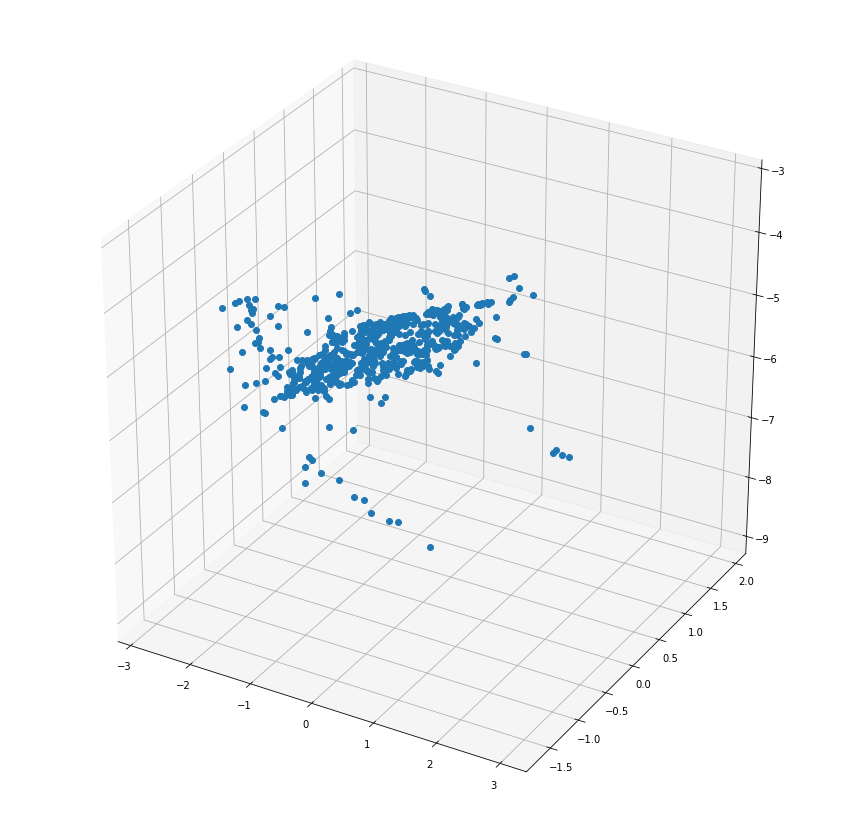

In [4]:
fig = plt.figure(figsize = [15,15])
ax = fig.gca(projection = "3d")
ax.view_init(elev = None, azim = None) #you can set elevation and azimuth with different values
ax.plot(points_3D[0], points_3D[1], points_3D[2], 'o')
plt.draw()
plt.show()

Now, we perform 3D projection for all the 3D points in house.p3d onto an image using the camera matrix P
defined above.

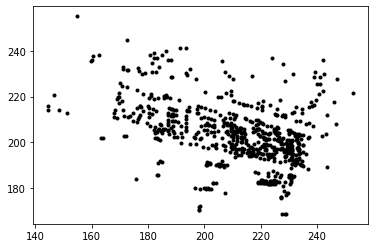

In [5]:
#projection
points_2D = project(P, points_3D)

#plot projection
plt.plot(points_2D[0], points_2D[1], 'k.')
plt.show()

## 2. Camera Pose Detection

In this section, I experiment with estimating the camera matrix P of a pin-hole camera given a set of 3D points and
their projected 2D locations. Suppose that we are given points_3D as a set of 3D points and points_2D as their
2D locations projected on an image. Suppose that P is unknown and we want to estimate it.

To do this we need atleast least 6 points to build the matrix.

However, points_3D contains more than 6 points. We can check this using the following commands.

In [6]:
print(points_2D.shape)
print(points_3D.shape)

(3, 672)
(4, 672)


To build the matrix A, we simply sample points_3D by taking the first 6 points from points_3D and their
corresponding 2D locations from points_2D. The sampled 3D points and corresponding 2D locations are stored
in points_3D_sampled and points_2D_sampled respectively

In [7]:
n_points = 6
points_3D_sampled = points_3D[:,:n_points]
points_2D_sampled = points_2D[:,:n_points]

You can now now build the matrix A from points_3D_sampled and points_2D_sampled as follows.

In [8]:
A = np.zeros((2*n_points, 12), np.float32)
for i in range(n_points):
    A[2*i,:4] = points_3D_sampled[:,i].T
    A[2*i,8:12] = -points_2D_sampled[0,i] * points_3D_sampled[:,i].T
    A[2*i+1,4:8] = points_3D_sampled[:,i].T
    A[2*i+1,8:12] = -points_2D_sampled[1,i] * points_3D_sampled[:,i].T

Given A, The problem is to find p such that Ap = 0. However, solving such a linear system
would result in trivial solution. We can double check this simply as,

In [9]:
p = linalg.solve(A, np.zeros((12, 1), np.float32))
print(p)

[[-0.]
 [ 0.]
 [-0.]
 [ 0.]
 [-0.]
 [ 0.]
 [-0.]
 [ 0.]
 [-0.]
 [-0.]
 [ 0.]
 [ 0.]]


C:\Users\justi\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: LinAlgWarning: Ill-conditioned matrix (rcond=3.74476e-12): result may not be accurate.
  """Entry point for launching an IPython kernel.


As shown, all the elements of p are zero, i.e., trivial solution. To address this issue, instead of directly solving Ap
= 0, we minimise ||Ap|| s.t. ||p|| = 1 using SVD (singular value decomposition) technique. In particular, we first
decompose A as,

In [10]:
U, S, V = linalg.svd(A)

Results of the above command include a matrix U, a vector S, and a matrix V satisfying U.diag(S).V<sup>T</sup> = A. 

Note that S is a sorted array of singular values with decreasing order. S contains 12 values and thus the S[11] is the
smallest singular value. We can verify this using the following command.

In [11]:
minS = np.min(S)
conditon = (S == minS)
minID = np.where(conditon)
print('index of the smallest singular value is: ', minID[0])

index of the smallest singular value is:  [11]


We finally compute P_hat (an estimate of P) by performing:
* Taking the row of V (i.e., column of V<sup>T</sup>) that corresponds to the smallest singular value (i.e., the last row)
* Express this column in a (3x4) matrix form
* Divide all elments of the matrix by the smallest singular value

In [12]:
P_hat = V[minID[0],:].reshape(3, 4) / minS

Now, we print both P and P_hat.

In [13]:
print(P)
print(P_hat)

[[100.   0. 200.   0.]
 [  0. 100. 200.   0.]
 [  0.   0.   1.   0.]]
[[-1.3976517e+05  1.3323917e+02 -2.7852638e+05  2.5185022e+03]
 [-2.2800359e+02 -1.3939970e+05 -2.7857684e+05  2.2643872e+03]
 [-1.1036053e+00  5.7202238e-01 -1.3929259e+03  1.1124268e+01]]


***P_hat*** does not seem to be close to ***P***! That's ok! In fact, two different camera matrices may produce the same
projected image due to the conversion from homogeneous to inhomogeneous. We now perform another test,
that is, to take a 3D point, project this 3D point to 2D using both ***P*** and ***P_hat*** and then compare the projection
results. 

To do so, we simply take the first point in points_3D_sampled and project it to 2D using ***P_hat***.

In [14]:
x_P_hat = project(P_hat, points_3D_sampled[:, 0])
print(x_P_hat)

[225.25375238 181.44421258   1.        ]


Now, we print the 2D location of that point from points_2D_sampled obtained by using ***P***.

In [15]:
x_P = points_2D_sampled[:,0]
print(x_P)

[225.25322768 181.44331296   1.        ]


Pretty Close!

For a quantitative evaluation, you can measure the distance between `x_P` and `x_P_hat` for all points in points_3D.
The smaller the distance is, the more accurate the estimation (of P) is.

In [16]:
x_P = points_2D
x_P_hat = project(P_hat, points_3D)
dist = 0

for i in range(x_P.shape[1]):
    dist += np.linalg.norm(x_P[:,i] - x_P_hat[:,i])
dist /= x_P.shape[1]
print(dist)

0.0028159418597439334


### Finding the best value for n_points

Create list of point samples percentages to test (10% - 100%) with 10% step size

In [17]:
points = []

for p in range(1, 11, 1):
    points.append(int(points_3D.shape[1]*p/10))

In [18]:
points

[67, 134, 201, 268, 336, 403, 470, 537, 604, 672]

create distance metric function for reuasbility

In [19]:
def distance_metric(points_2D, points_3D, P_hat):
    x_P = points_2D
    x_P_hat = project(P_hat, points_3D)
    dist = 0

    for i in range(x_P.shape[1]):
        dist += np.linalg.norm(x_P[:,i] - x_P_hat[:,i])
    dist /= x_P.shape[1]
    return dist

loop over logic with each point percentage and print the results.

In [20]:
import pandas as pd

In [21]:
distances = pd.DataFrame(columns={'points', 'percentage', 'distance'})

percentage = 0

for p in points:
    points_3D_sampled = points_3D[:,:p]
    points_2D_sampled = points_2D[:,:p]

    A = np.zeros((2*p, 12), np.float32)
    for i in range(p):
        A[2*i,:4] = points_3D_sampled[:,i].T
        A[2*i,8:12] = -points_2D_sampled[0,i] * points_3D_sampled[:,i].T
        A[2*i+1,4:8] = points_3D_sampled[:,i].T
        A[2*i+1,8:12] = -points_2D_sampled[1,i] * points_3D_sampled[:,i].T
        
    U, S, V = linalg.svd(A)
    minS = np.min(S)
    conditon = (S == minS)
    minID = np.where(conditon)
    P_hat = V[minID[0],:].reshape(3, 4) / minS
    
    
    percentage += 0.1
        
    print(f'points sampled: {p} - distance: {distance_metric(points_2D, points_3D, P_hat):.5f}')
    distances = distances.append({'points': p, 
                                  'percentage' : percentage,
                                  'distance': distance_metric(points_2D, points_3D, P_hat),
                                  },
                                 ignore_index=True)
    

points sampled: 67 - distance: 0.00132
points sampled: 134 - distance: 0.00143
points sampled: 201 - distance: 0.00289
points sampled: 268 - distance: 0.00112
points sampled: 336 - distance: 0.00204
points sampled: 403 - distance: 0.00131
points sampled: 470 - distance: 0.00284
points sampled: 537 - distance: 0.00154
points sampled: 604 - distance: 0.00424
points sampled: 672 - distance: 0.00143


In [22]:
import seaborn as sns

[Text(0, 0, '10.00%'),
 Text(0, 0, '20.00%'),
 Text(0, 0, '30.00%'),
 Text(0, 0, '40.00%'),
 Text(0, 0, '50.00%'),
 Text(0, 0, '60.00%'),
 Text(0, 0, '70.00%'),
 Text(0, 0, '80.00%'),
 Text(0, 0, '90.00%'),
 Text(0, 0, '100.00%')]

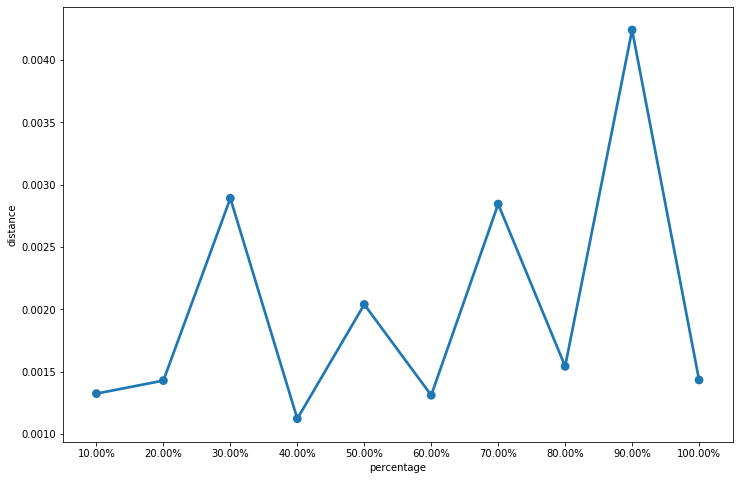

In [23]:
plt.figure(figsize=(12,8))
g = sns.pointplot(y='distance', x='percentage', data=distances)
xlabels = ['{:,.2f}'.format(x) + '%' for x in g.get_xticks()*10+10]
g.set_xticklabels(xlabels)

In this section I experimented with a varying amount of sampled points from a 3D point space projected onto a 2D space to estimate the camera parameter matrix p. In this experimentation I trailed using various percentages of the available points all the way up until 100% and recorded the corresponding Euclidean distances. 

My initial expectation was that the higher the sampling %, the lower (better) distance metric. This expectation was proven incorrect. This is because as the percentage of points increase, the independence in the matrix A may not increase at the same rate. We can see the lowest (best) distance score was obtained with 40% of the points. There was also an interesting cycling effect at 40%, 60% and 80%.

## 3.3D Reconstruction

In this section I use the structure-from-motion approach to compare the key points between 2 images, one using SIFT and one using structure-from-motion. The 2 images can be seen side-by-side below. They show Alcatraz prison from 2 slightly different perspectives.

In [34]:
import homography
import sfm
import ransac

(-0.5, 3871.5, 1295.5, -0.5)

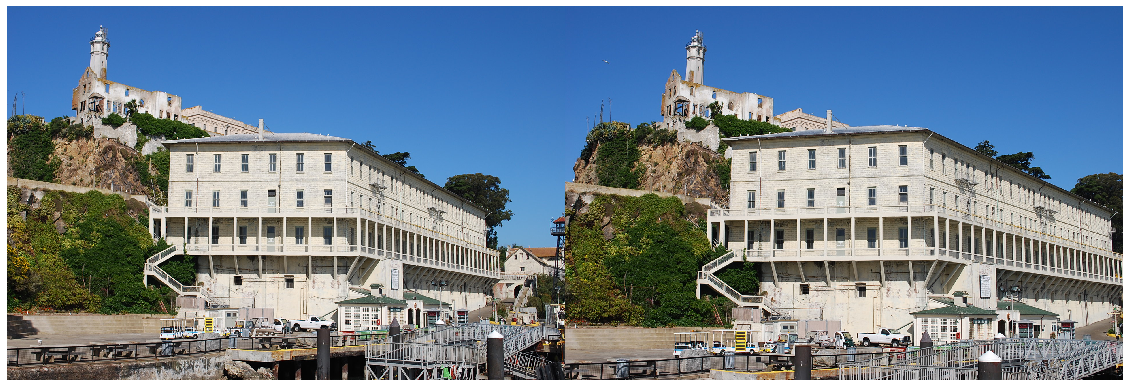

In [25]:
import cv2 as cv

sift = cv.xfeatures2d.SIFT_create()

img1 = cv.imread('./resources/alcatraz1.jpg')
img1_gray = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
kp1, des1 = sift.detectAndCompute(img1_gray, None)

img2 = cv.imread('./resources/alcatraz2.jpg')
img2_gray = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)
kp2, des2 = sift.detectAndCompute(img2_gray, None)

img1_2 = np.hstack((img1, img2))

plt.figure(figsize = (20, 10))
plt.imshow(img1_2[:,:,::-1])

plt.axis('off')

I then plot the various keypoints in the images

Number of detected keypoints in img1: 25472
Number of detected keypoints in img2: 24553


(-0.5, 3871.5, 1295.5, -0.5)

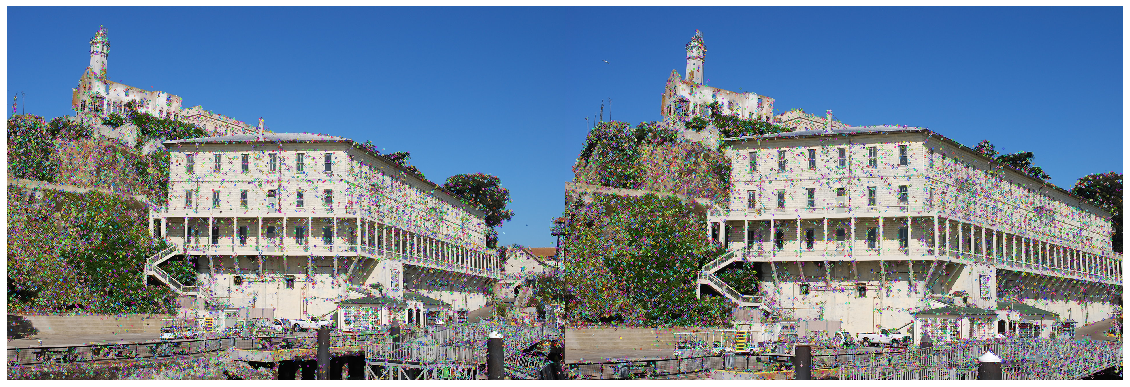

In [26]:
img1_kp = img1.copy()
img1_kp = cv.drawKeypoints(img1, kp1, img1_kp)
print("Number of detected keypoints in img1: %d" % (len(kp1)))

img2_kp = img2.copy()
img2_kp = cv.drawKeypoints(img2, kp2, img2_kp)
print("Number of detected keypoints in img2: %d" % (len(kp2)))

img1_2_kp = np.hstack((img1_kp, img2_kp))

plt.figure(figsize = (20, 10))
plt.imshow(img1_2_kp[:,:,::-1])

plt.axis('off')

We match descriptors in des1 and those in des2 using cv.BFMatcher as follows.

In [27]:
bf = cv.BFMatcher(crossCheck = True) #crossCheck = True means we want to find consistent matches
matches = bf.match(des1, des2)
matches = sorted(matches, key = lambda x:x.distance)
print("Number of consistent matches: %d" % len(matches))

Number of consistent matches: 14401


The best 20 matches are visualised as follows.

(-0.5, 3871.5, 1295.5, -0.5)

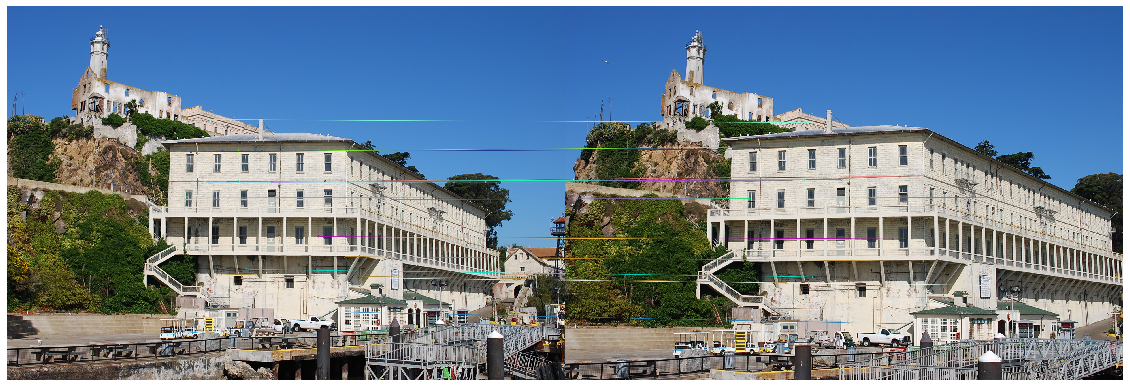

In [28]:
img1_2_matches = cv.drawMatches(img1, kp1, img2, kp2,
                                matches[:20],
                                None,
                                flags = cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize = (20, 10))
plt.imshow(img1_2_matches[:,:,::-1])
plt.axis('off')

The number of matches is 14401 which requires high computational complexity for further steps. To be more
practical, we could reduce the number of matches to some smaller number, e.g., 1000 matches. Given a fixed
number of matches, we identify the corresponding matching keypoints and store them in arrays for later use as
follows.

In [29]:
n_matches = 1000

kp1_array = np.zeros((2, n_matches), np.float32)
for i in range(n_matches):
    kp1_array[0][i] = kp1[matches[i].queryIdx].pt[0]
    kp1_array[1][i] = kp1[matches[i].queryIdx].pt[1]

kp2_array = np.zeros((2, n_matches), np.float32)
for i in range(n_matches):
    kp2_array[0][i] = kp2[matches[i].trainIdx].pt[0]
    kp2_array[1][i] = kp2[matches[i].trainIdx].pt[1]

We convert all the keypoints into homogeneous coordinates.

In [30]:
x1 = homography.make_homog(kp1_array)
x2 = homography.make_homog(kp2_array)

Suppose that the intrinsic calibration matrix K is given, and we fix P1=[I|0], we need to find P2

In [31]:
K = np.array([[2394,0,932], [0,2398,628], [0,0,1]])
P1 = np.array([[1,0,0,0], [0,1,0,0], [0,0,1,0]])

We normalise x1 and x2 using K<sup>-1</sup>.

In [32]:
x1n = np.dot(linalg.inv(K), x1)
x2n = np.dot(linalg.inv(K), x2)

We estimate the essential matrix E. 

**Note:** this step takes time.

In [35]:
#estimate E with RANSAC
model = sfm.RansacModel()
E, inliers = sfm.F_from_ransac(x1n, x2n, model)

We then compute P2.

In [36]:
#compute camera matrices (P2 will be list of four solutions)
P2_all = sfm.compute_P_from_essential(E)

#pick the solution with points in front of cameras
ind = 0
maxres = 0

for i in range(4):
    #triangulate inliers and compute depth for each camera
    X = sfm.triangulate(x1n[:, inliers], x2n[:, inliers], P1, P2_all[i])
    d1 = np.dot(P1, X)[2]
    d2 = np.dot(P2_all[i], X)[2]
    s = sum(d1 > 0) + sum(d2 > 0)
    if s > maxres:
        maxres = s
        ind = i
        infront = (d1 > 0) & (d2 > 0)
    
P2 = P2_all[ind]

Finally, we reconstruct 3D points using the triangulation algorithm

In [37]:
#triangulate inliers and remove points not in front of both cameras
X = sfm.triangulate(x1n[:, inliers], x2n[:, inliers], P1, P2)
X = X[:, infront]

In [38]:
print(len(X[0]))

810


We visualise X using the following code.

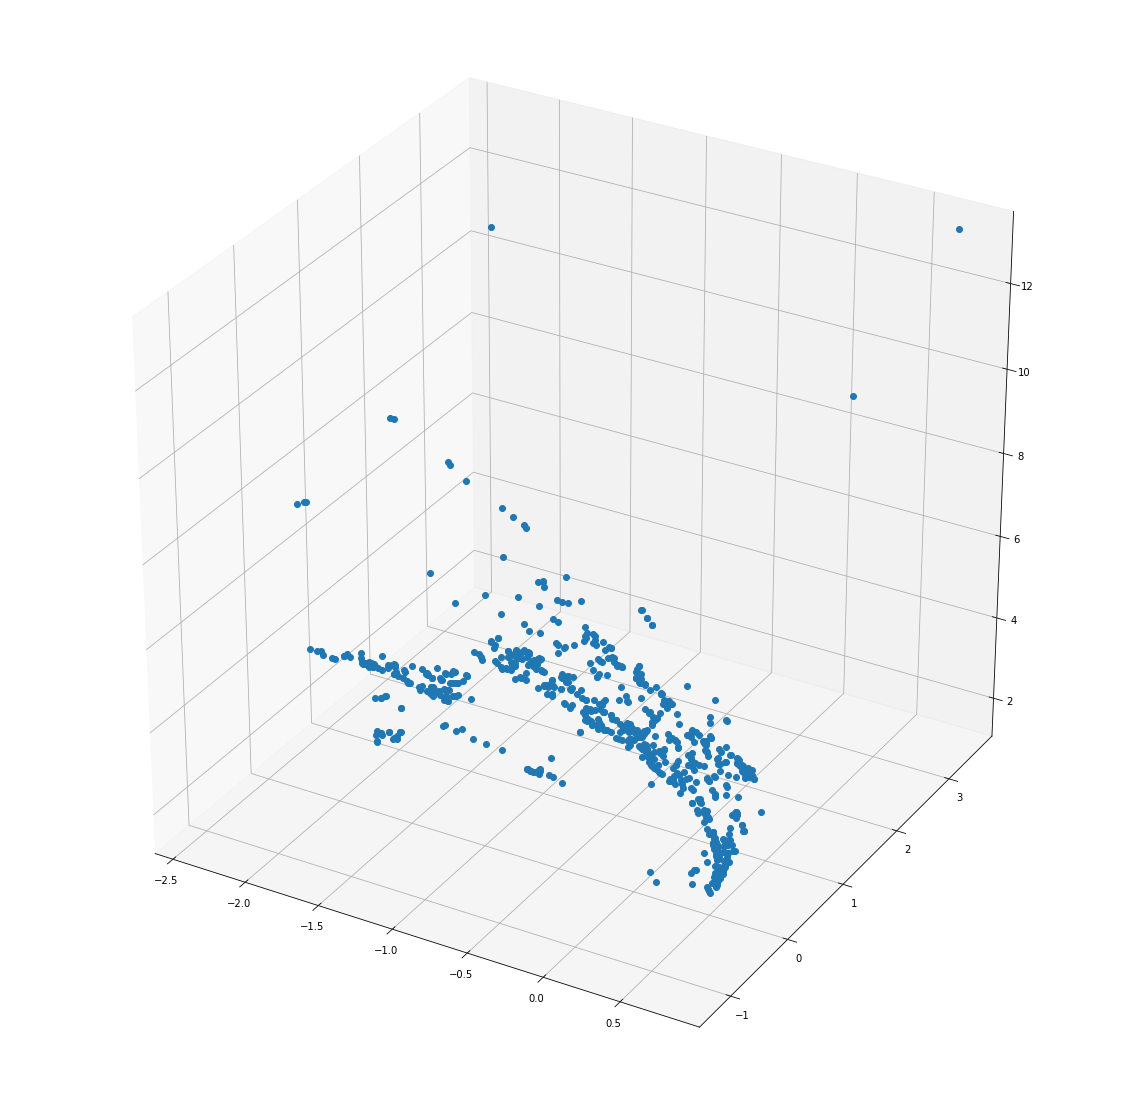

In [39]:
#3D plot
fig = plt.figure(figsize = [20,20])

ax = fig.gca(projection = "3d")
ax.view_init(elev = None, azim = None) #you can set elevation and azimuth with different values

ax.plot(X[0], X[1], X[2], 'o')

plt.draw()
plt.show()

I can then visualise the original points (computed using SIFT) on img2 and the image points (computed by
projecting X with camera matrix P2) on img2.

In [40]:
x2p = project(P2, X)
x2p = np.dot(K, x2p)

In [41]:
x2[0].shape

(1000,)

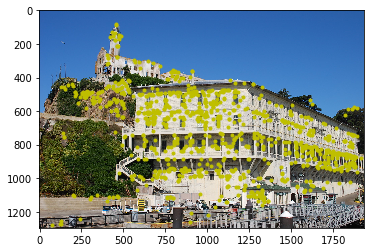

In [42]:
plt.figure()
plt.imshow(img2[:,:,::-1])
plt.plot(x2[0], x2[1], 'y.')

In [43]:
x2p[0].shape

(810,)

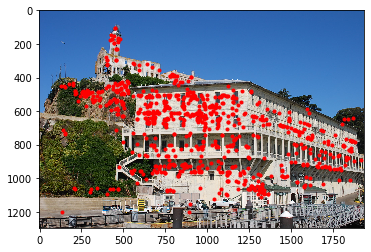

In [44]:
plt.figure()
plt.imshow(img2[:,:,::-1])
plt.plot(x2p[0], x2p[1], 'r.')

In the images abnove I have plotted the results of the SIFT detect and SFM approaches. The first observation is the number of points. The SIFT plot has 1000 points (because we selected the top 1000 key points) and the SFM results in 810 points. The reduction in points is a result of the descriptor matching using the crossCheck parameter in the cv.BFMatcher. This ensures that we only match consistent matches between the 2 images.

Despite the ~20% reduction in points, the SFM approach captures the same key areas of the image as the SIFT approach. For example, the top of the lighthouse has a similar cluster of points, the cliff face has a similar cluster, as well as the building and window features. The clusters of points are only those parts of the image that are commonly shared by both images. You can see this from the jetty in the bottom right. In img1 this part is captured at an angle that makes the descriptors not match. As a result, there is no key points or descriptors for this part of the image.